<a href="https://colab.research.google.com/github/lgvaz/faststyle/blob/master/examples/hats_on_cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !nvidia-smi

In [2]:
# !pip install -q fastai2
# !gdown https://drive.google.com/uc?id=1WcxHwzvhFuzwWPEwiNr4prozGIWQtOVu
# !unzip -q cats.zip

In [3]:
from fastai2.basics import *
from fastai2.vision.all import *
from faststyle import *
from torchvision.models import vgg16,vgg19,vgg16_bn,vgg19_bn

In [4]:
source = Path('/home/lgvaz/.data/cats')

## All stuff for putting hats on kitties
Yeah, needs a refactor

In [5]:
def get_y_fn(fn): return fn.with_suffix(fn.suffix+'.cat')
def get_kpts(fn): return np.genfromtxt(fn)[1:].reshape(-1,2)
def get_y(fn):    return get_kpts(get_y_fn(fn))

In [6]:
class CatPoint(TensorPoint):
  @property
  def eyes(self): return (self[0], self[1])
  @property
  def ears(self): return (self[3:6], self[6:9])
  @property
  def leye(self): return min(self.eyes, key=itemgetter(0))
  @property
  def reye(self): return max(self.eyes, key=itemgetter(0))
  @property
  def mouth(self): return self[2]
  @property
  def lear(self): return min(self.ears, key=lambda x: x[0][0])
  @property
  def rear(self): return max(self.ears, key=lambda x: x[0][0])
  @property
  def flip(self): return bool(self.eyes[0][0] > self.eyes[1][0])
  
  # this fails if you dont override
  @classmethod
  def create(cls, t, img_size=None)->None:
    "Convert an array or a list of points `t` to a `Tensor`"
    return cls(tensor(t).view(-1, 2).float(), img_size=img_size)

In [7]:
def get_head_pnts(pt):
  left,top = pt.lear.min(axis=0)[0].numpy()
  right,_  = pt.rear.max(axis=0)[0].numpy()
  bottom = min(pt.leye[1], pt.reye[1])
  pnts = np.array([left,top,right,bottom], dtype=int)
  return pnts

In [ ]:
def get_angle(pt):
  x,y = pt.rear[-1] - pt.lear[0] 
  slope = np.divide(y,x, where=x!=0)
  return -np.arctan(slope) * (180/np.pi) + (180 if pt.flip else 0)

In [ ]:
def get_size(pnts):
  return pnts[2:]-pnts[:2]

In [10]:
def unscale_pnts(y, sz): return CatPoint((y+1) * tensor(sz).float()/2, img_size=sz)

In [11]:
hat = PILImage.create('hats/hat1.png', mode='RGBA')
def get_hat_pt(pt):
  head = get_head_pnts(pt)
  w,_ = get_size(head)
  # Substitute top of head to maintain hat ratio
  h = w/np.divide(*hat.size)
  if pt.flip: head[-1] = head[1] + h
  else:       head[1] = head[-1] - h
  return head

In [12]:
def put_hat(im, cat_pt, hat_pt, hat):
  im = im.copy()
  hat = hat.resize(get_size(hat_pt)).rotate(get_angle(cat_pt))
  im.paste(hat, hat_pt, hat)
  return im

In [13]:
def get_y2(fn):
  cat_pt = CatPoint.create(get_y(fn))
  hat_pt = get_hat_pt(cat_pt)
  im = PILImage.create(fn)
  im = put_hat(im, cat_pt, hat_pt, hat)
  return PILImage(im)

## Datablocks and usual stuff

In [14]:
dblock = DataBlock(style_blocks, get_y=get_y2,
                   get_items=get_image_files, splitter=RandomSplitter(.1),
                   item_tfms=[Resize(128)], batch_tfms=[NormalizeX.from_stats(*imagenet_stats)])

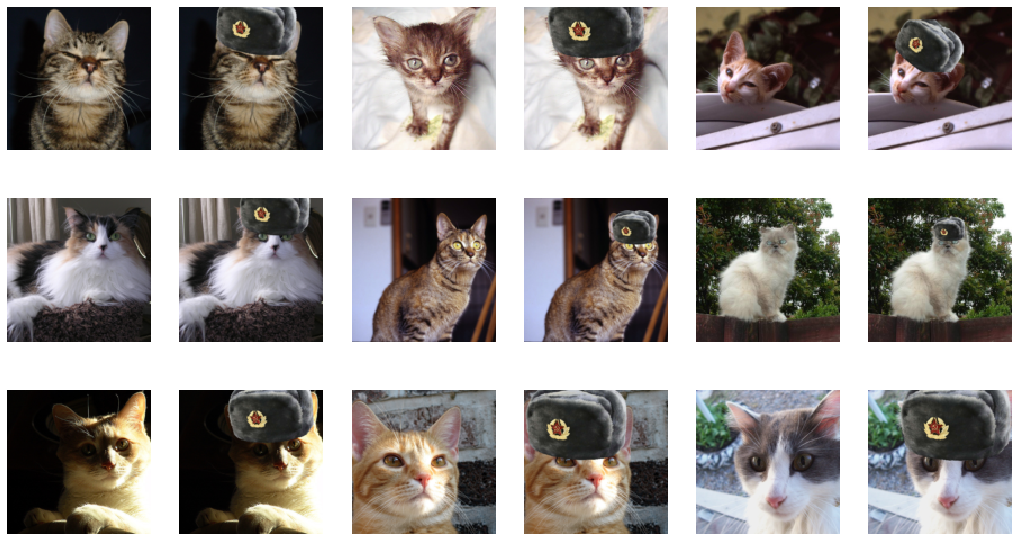

In [15]:
dls = dblock.dataloaders(source, bs=30); dls.c = 3
dls.show_batch()

In [16]:
feat_m = prepare_feat_model(vgg16_bn(True).features)
get_fts = LayerFeats(feat_m, stl_ls=[], cnt_ls=get_layers(feat_m, [12,22,32]),
                     tfms=NormalizeAll.from_stats(*imagenet_stats))

In [17]:
cnt_loss = partial(content_loss, layer_ws=[5,15,2])
loss_func = SuperResLoss(cnt_loss=cnt_loss)

In [18]:
cbs = [FeatsCallback(get_fts)]
metrics = loss_func.metrics
cfg = unet_config(blur=True, self_attention=True, norm_type=NormType.Weight, y_range=(0.,1.))
learn = unet_learner(dls=dls, arch=resnet34, loss_func=loss_func, cbs=cbs,
                     metrics=metrics, config=cfg)

(0.15848932266235352, 0.002511886414140463)

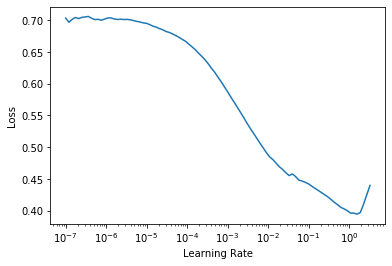

In [19]:
learn.lr_find()

In [20]:
# 0.07
learn.fit_one_cycle(3, 1e-2, pct_start=.9)

epoch,train_loss,valid_loss,pixel,cnt,time
0,0.118368,0.114401,0.006007,0.108395,03:05
1,0.083434,0.091897,0.004912,0.086985,03:02
2,0.067681,0.068674,0.003575,0.065099,03:02


(3.0199518619156154e-08, 9.12010818865383e-07)

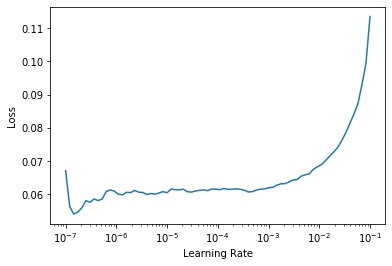

In [22]:
learn.unfreeze()
learn.lr_find()

In [23]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-6,1e-4), pct_start=0.9)

epoch,train_loss,valid_loss,pixel,cnt,time
0,0.060254,0.067433,0.003516,0.063917,03:11
1,0.059022,0.065828,0.003363,0.062465,03:12
2,0.057874,0.064640,0.003276,0.061364,03:12


In [25]:
learn.fit_one_cycle(3, slice(1e-4,1e-3), pct_start=0.1)

epoch,train_loss,valid_loss,pixel,cnt,time
0,0.056281,0.062692,0.003086,0.059605,03:10
1,0.051336,0.057955,0.002817,0.055138,03:19
2,0.046297,0.055591,0.002651,0.052940,03:15


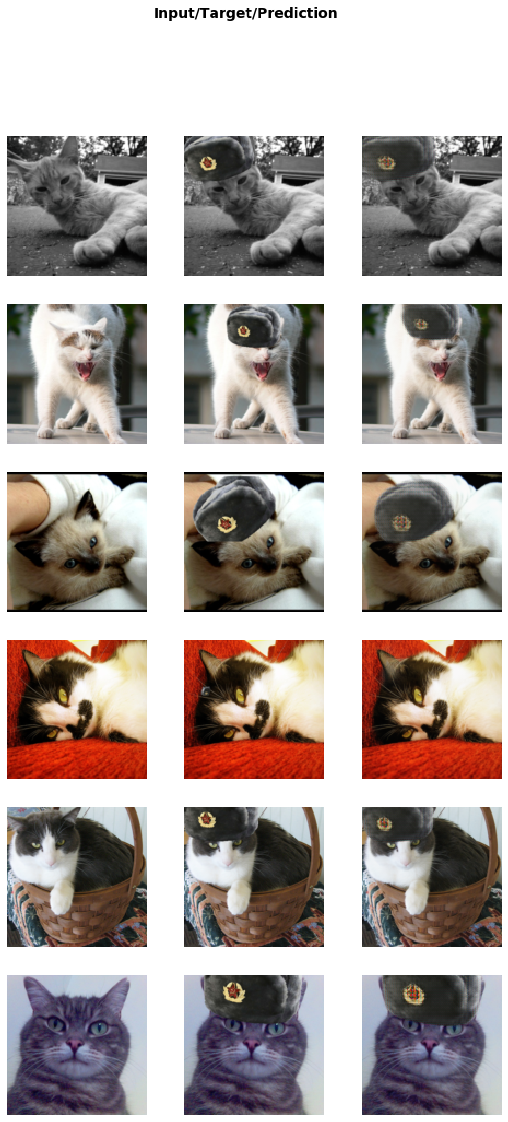

In [26]:
learn.show_results()

In [23]:
learn.save('stage1')

(6.918309736647643e-07, 9.12010818865383e-07)

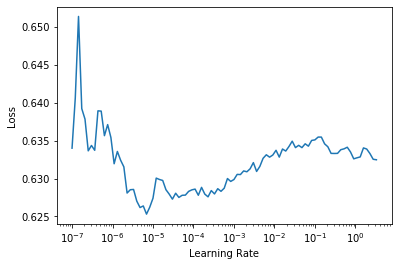

In [24]:
learn.unfreeze()
learn.lr_find()

In [25]:
learn.fit_one_cycle(6, slice(1e-6,1e-4), pct_start=0.72)

epoch,train_loss,valid_loss,pixel,cnt,time
0,0.625428,0.624620,0.406003,0.218617,02:46
1,0.628055,0.624620,0.406003,0.218617,02:48
2,0.626327,0.624620,0.406003,0.218617,02:53
3,0.626953,0.624620,0.406003,0.218617,02:54
4,0.625873,0.624620,0.406003,0.218617,02:54
5,0.629501,0.624620,0.406003,0.218617,02:54


In [26]:
learn.save('stage2')

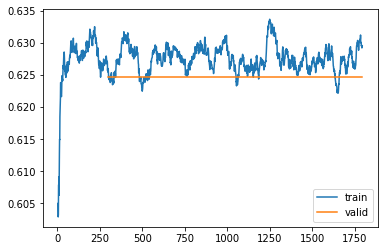

In [27]:
learn.recorder.plot_loss()

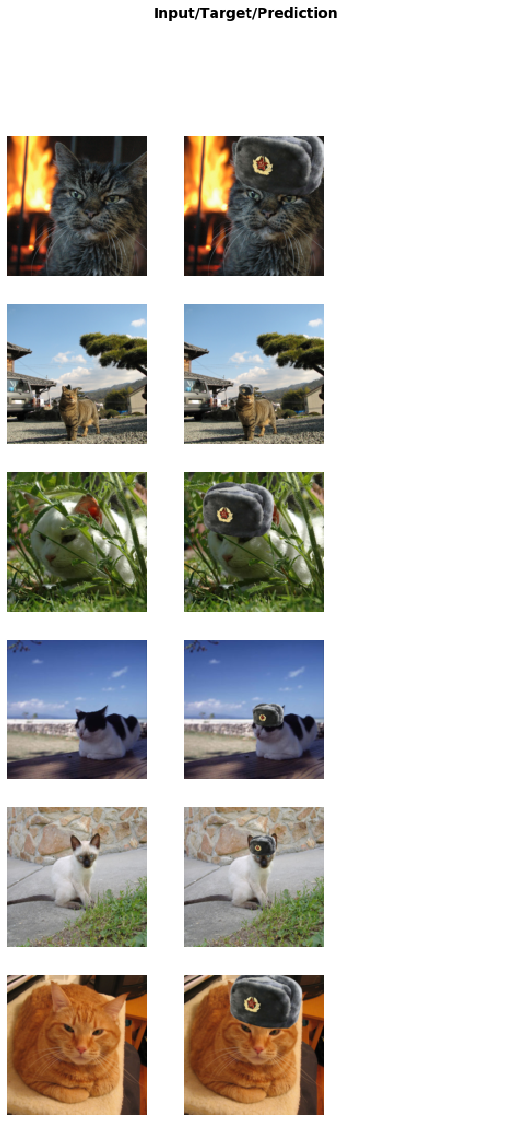

In [29]:
learn.show_results()